In [1]:
import numpy as np
from random import shuffle


import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# LinearSVM

- multi-classifier SVM 

$$ s^i = Wx_i $$

$$ L_i = \sum_{j}{\max\left( 0, s_j^{i} - s^{i}_{y_i} + \Delta \right)} $$

$$ L = \lambda R(W) + \sum_{i}{L_i} $$

- binaray-classifier SVM

$$ L_i = \max(0, 1-y_i*y_{pred}) $$

$$ y_{pred} = W^{T}x_i $$

- **More**

                                           https://cs231n.github.io/linear-classify/

In [2]:
def svm_loss_naive(W, X, y, reg):
  """
  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.
  
  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss (float)
  - dW (D, C)
  """
  dW = np.zeros(W.shape)
  loss = 0.0
  num_classes = W.shape[1]
  num_train = X.shape[0]

  for i in range(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    num_classes_greater_margin = 0
    for j in range(num_classes):

      # Skip if images target class, no loss computed for that case.
      if j == y[i]:
        continue

      # Calculate our margin, delta = 1
      margin = scores[j] - correct_class_score + 1

      # Only calculate loss and gradient if margin condition is violated.
      if margin > 0:
        num_classes_greater_margin += 1
        # Gradient for non correct class weight.
        dW[:, j] = dW[:, j] + X[i, :]
        loss += margin

    # Gradient for correct class weight.
    dW[:, y[i]] = dW[:, y[i]] - X[i, :]*num_classes_greater_margin
    
  # Average our data loss across the batch.
  loss /= num_train
  # Add regularization loss to the data loss.
  loss += reg * np.sum(W * W)
  # Average our gradient across the batch and add gradient of regularization term.
  dW = dW /num_train + 2*reg *W
  return loss, dW

In [3]:
def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero
  num_train = X.shape[0]
  scores = np.dot(X, W)

  correct_class_scores = np.choose(y, scores.T)  # np.choose uses y to select elements from scores.T

  # Need to remove correct class scores as we dont calculate loss/margin for those.
  mask = np.ones(scores.shape, dtype=bool)
  mask[range(scores.shape[0]), y] = False
  scores_ = scores[mask].reshape(scores.shape[0], scores.shape[1]-1)

  # Calculate our margins all at once.
  margin = scores_ - correct_class_scores[:, np.newaxis] + 1

  # Only add margin to our loss if it's greater than 0, let's make
  # negative margins =0 so they dont change our loss.
  margin[margin < 0] = 0

  # Average our data loss over the size of batch and add reg. term to the loss.
  loss = np.sum(margin) / num_train
  loss += reg * np.sum(W * W)

  original_margin = scores - correct_class_scores[:,np.newaxis] + 1

  # Mask to identiy where the margin is greater than 0 (all we care about for gradient).
  pos_margin_mask = (original_margin > 0).astype(float)

  # Count how many times >0 for each image but dont count correct class hence -1
  sum_margin = pos_margin_mask.sum(1) - 1

  # Make the correct class margin be negative total of how many > 0
  pos_margin_mask[range(pos_margin_mask.shape[0]), y] = -sum_margin

  # Now calculate our gradient.
  dW = np.dot(X.T, pos_margin_mask)

  # Average over batch and add regularisation derivative.
  dW = dW / num_train + 2 * reg * W

  return loss, dW

In [4]:
from data_utils import load_CIFAR10
X_train, y_train, X_test, y_test = load_CIFAR10('datasets/cifar-10-batches-py')

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## check pictures in cifar-10

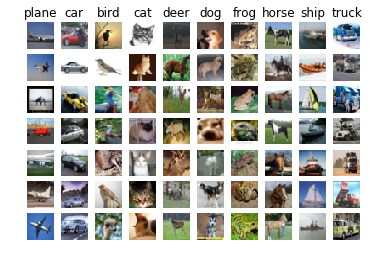

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
num_training = 49000
num_dev = 500

num_validation = 1000
num_test = 1000


# X_train => X_train + X_val
X_val = X_train[49000:50000]
y_val = y_train[49000:50000]

X_train = X_train[0:49000]
y_train = y_train[0:49000]


mask = np.random.choice(49000, 500, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = np.random.choice(10000, 1000, replace=False)
X_test = X_test[mask]
y_test = y_test[mask]


X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Dev Data(rand from X_train) shape: ', X_dev.shape)
print('Dev lables shape: ', y_dev.shape)
print('Test data (rand from X_test) shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Dev Data(rand from X_train) shape:  (500, 3072)
Dev lables shape:  (500,)
Test data (rand from X_test) shape:  (1000, 3072)
Test labels shape:  (1000,)


In [7]:
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image
print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3072) (1000, 3072) (1000, 3072) (500, 3072)


In [8]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [9]:
from gradient_check import  grad_check_sparse
W = np.random.randn(3073, 10) * 0.0001
loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
f = lambda w: svm_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)
# same as 'loss'

numerical: -8.597784 analytic: -8.597784, relative error: 1.065056e-12
numerical: 0.717202 analytic: 0.717202, relative error: 6.948733e-10
numerical: -6.803692 analytic: -6.803692, relative error: 6.864204e-11
numerical: 15.985266 analytic: 15.985266, relative error: 2.599200e-11
numerical: 20.364796 analytic: 20.364796, relative error: 2.003269e-11
numerical: 16.079040 analytic: 16.079040, relative error: 3.705969e-11
numerical: -15.525209 analytic: -15.525209, relative error: 1.663706e-11
numerical: 9.946205 analytic: 9.946205, relative error: 2.204818e-11
numerical: 9.642662 analytic: 9.642662, relative error: 2.541478e-11
numerical: 1.073994 analytic: 1.073994, relative error: 7.260712e-10


## Solver

In [10]:
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
         training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
         means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # list of integers between 0 and length of X (these are our indices
    X_indices = np.arange(num_train)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      batch_indices = np.random.choice(X_indices,batch_size)
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]
    
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)
      
      self.W += -(learning_rate * grad)
    
      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    pred_scores = np.dot(X,self.W)
    y_pred = np.argmax(pred_scores, axis=1)
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass

In [11]:
class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


In [12]:
svm = LinearSVM()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)

iteration 0 / 1500: loss 799.259213
iteration 100 / 1500: loss 289.589857
iteration 200 / 1500: loss 108.838204
iteration 300 / 1500: loss 42.596826
iteration 400 / 1500: loss 19.245404
iteration 500 / 1500: loss 10.183481
iteration 600 / 1500: loss 7.305976
iteration 700 / 1500: loss 6.085186
iteration 800 / 1500: loss 6.054023
iteration 900 / 1500: loss 4.507560
iteration 1000 / 1500: loss 5.346688
iteration 1100 / 1500: loss 5.267411
iteration 1200 / 1500: loss 4.838569
iteration 1300 / 1500: loss 5.279018
iteration 1400 / 1500: loss 5.115032


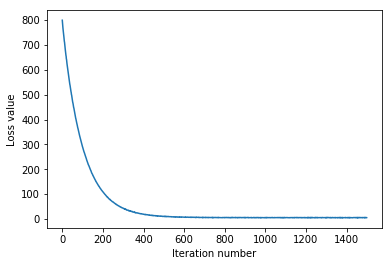

In [13]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [14]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371898
validation accuracy: 0.378000


# Soft Max

$$ L_i = - \log(\frac{e^{s_{y_i} - \max(s_j)}}{\sum_{j}{e^{{s_j}-\max(s_j)}}}) $$

$$ f_j = s_j - \max(s_j) $$

other variables definations: reference SVM.

- formular https://cs231n.github.io/linear-classify/


- derivatives

![](img/solve.png)


In [15]:
def softmax_loss_naive(W, X, y, reg):
  """
  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss (float)
  - gradient (D, C)
  """
  loss = 0.0
  dW = np.zeros_like(W)

  num_classes = W.shape[1]
  num_train = X.shape[0]

  scores = np.dot(X, W)

  # Calculate loss and gradient for each element of our batch.
  for ii in range(num_train):
    current_scores = scores[ii, :]

    # Fix for numerical stability by subtracting max from score vector.
    shift_scores = current_scores - np.max(current_scores)

    # Calculate loss for this example.
    loss_ii = -shift_scores[y[ii]] + np.log(np.sum(np.exp(shift_scores)))
    loss += loss_ii

    for jj in range(num_classes):
      softmax_score = np.exp(shift_scores[jj]) / np.sum(np.exp(shift_scores))

      # Gradient calculation.
      if jj == y[ii]:
        dW[:, jj] += (-1 + softmax_score) * X[ii]
      else:
        dW[:, jj] += softmax_score * X[ii]

  # Average over the batch and add our regularization term.
  loss /= num_train
  loss += reg * np.sum(W*W)

  # Average over the batch and add derivative of regularization term.
  dW /= num_train
  dW += 2*reg*W
    
  return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)
  num_train = X.shape[0]

  # Calculate scores and numeric stability fix.
  scores = np.dot(X, W)
  shift_scores = scores - np.max(scores, axis=1)[...,np.newaxis]

  # Calculate softmax scores.
  softmax_scores = np.exp(shift_scores)/ np.sum(np.exp(shift_scores), axis=1)[..., np.newaxis]

  # Calculate dScore, the gradient wrt. softmax scores.
  dScore = softmax_scores
  dScore[range(num_train),y] = dScore[range(num_train),y] - 1

  # Backprop dScore to calculate dW, then average and add regularisation.
  dW = np.dot(X.T, dScore)
  dW /= num_train
  dW += 2*reg*W

  # Calculate our cross entropy Loss.
  correct_class_scores = np.choose(y, shift_scores.T)  # Size N vector
  loss = -correct_class_scores + np.log(np.sum(np.exp(shift_scores), axis=1))
  loss = np.sum(loss)

  # Average our loss then add regularisation.
  loss /= num_train
  loss += reg * np.sum(W*W)

  return loss, dW


In [16]:
class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)
